In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import os
import sys
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- 0. Carregamento dos Dados Pré-Processados ---


In [2]:
processed_data_input_path = '../data/processed/'
df_processed_filename = os.path.join(processed_data_input_path, 'df_processed_for_modeling.csv')

try:
    df_final = pd.read_csv(df_processed_filename)
    print(f"DataFrame final processado carregado com sucesso de '{df_processed_filename}'!")
except FileNotFoundError:
    print(f"Erro: Arquivo '{df_processed_filename}' não encontrado.")
    print("Certifique-se de que o notebook '02_feature_engineering_and_pipeline_training.ipynb' foi executado e salvou 'df_processed_for_modeling.csv'.")
    exit()

DataFrame final processado carregado com sucesso de '../data/processed/df_processed_for_modeling.csv'!


In [3]:
# Calcula o caminho para a raiz do projeto (um nível acima da pasta 'notebooks')
# os.getcwd() -> project_root/notebooks/
# os.path.abspath(os.path.join(os.getcwd(), '..')) -> project_root/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adiciona a raiz do projeto ao PYTHONPATH se ainda não estiver lá
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Adicionado '{project_root}' ao sys.path para importações.")
else:
    print(f"'{project_root}' já está no sys.path.")

# Agora, importe a classe a partir de src.utils
from src.utils.custom_transformers import DateFeatureEngineer
print("DateFeatureEngineer importado com sucesso!")

Adicionado 'c:\Users\murilo.weber\projetos_portfolio\tcrm_opportunity_loss_prediction' ao sys.path para importações.
DateFeatureEngineer importado com sucesso!


In [4]:
# Carregar o pipeline de pré-processamento salvo
models_dir = '../models/'
preprocessor_pipeline_path = os.path.join(models_dir, 'preprocessor_pipeline.joblib')

try:
    preprocessor = joblib.load(preprocessor_pipeline_path)
    print(f"Pipeline de pré-processamento carregado com sucesso de '{preprocessor_pipeline_path}'!")
except FileNotFoundError:
    print(f"Erro: Arquivo '{preprocessor_pipeline_path}' não encontrado.")
    print("Certifique-se de que o notebook '02_feature_engineering_and_pipeline_training.ipynb' foi executado e salvou 'preprocessor_pipeline.joblib'.")
    exit()

Pipeline de pré-processamento carregado com sucesso de '../models/preprocessor_pipeline.joblib'!


In [5]:
# Definir X e y a partir do df_final carregado
X = df_final.drop('target', axis=1)
y = df_final['target']

In [6]:
# Divisão dos dados em treino e teste (X e y brutos do df_final)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n--- Dados brutos (df_final) divididos em Treino ({X_train_raw.shape[0]} amostras) e Teste ({X_test_raw.shape[0]} amostras) ---")


--- Dados brutos (df_final) divididos em Treino (6160 amostras) e Teste (2640 amostras) ---


# --- 1. Experimentação: Regressão Logística ---

In [7]:
print("\n--- Experimentando: Regressão Logística ---")


--- Experimentando: Regressão Logística ---


In [8]:
# Aplicar o pré-processador aos dados de treino e teste

X_train_processed = preprocessor.transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

### 1.1. Instanciar o Modelo

In [9]:
# Usar solver='liblinear' é robusto para datasets menores e para penalidade L1/L2.
# 'random_state' para reprodutibilidade dos resultados.
lr_model = LogisticRegression(solver='liblinear', random_state=42)

## 1.2. Treinar o Modelo

In [10]:
# O modelo aprende os padrões a partir dos dados de treinamento (X_train, y_train).
lr_model.fit(X_train_processed, y_train)
print("\n--- Modelo de Regressão Logística Treinado com Sucesso! ---")


--- Modelo de Regressão Logística Treinado com Sucesso! ---


# --- 2. Avaliação do Modelo (Métricas Iniciais) ---

In [11]:
print("\n--- Avaliando o Modelo no Conjunto de Teste ---")


--- Avaliando o Modelo no Conjunto de Teste ---


## 2.1. Fazer Previsões no conjunto de Teste

In [13]:
# 'y_pred' são as classes previstas (0 ou 1).
y_pred_lr = lr_model.predict(X_test_processed)
# 'y_prob' são as probabilidades da classe positiva (target = 1, ou seja, 'perda').
y_pred_proba_lr = lr_model.predict_proba(X_test_processed)[:, 1]

In [14]:
print("\n--- Relatório de Classificação no Conjunto de Teste ---")
print(classification_report(y_test, y_pred_lr))
print(f"AUC-ROC Score - Regressão Logística (Teste): {roc_auc_score(y_test, y_pred_proba_lr):.4f}")


--- Relatório de Classificação no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.63      0.92      0.75      1665
           1       0.32      0.06      0.11       975

    accuracy                           0.60      2640
   macro avg       0.47      0.49      0.43      2640
weighted avg       0.51      0.60      0.51      2640

AUC-ROC Score - Regressão Logística (Teste): 0.5827


In [15]:
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)


--- Matriz de Confusão ---
[[1535  130]
 [ 913   62]]


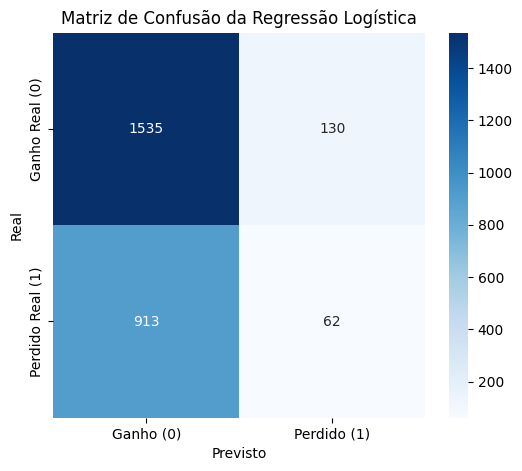

In [16]:
# Visualizar a Matriz de Confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ganho (0)', 'Perdido (1)'],
            yticklabels=['Ganho Real (0)', 'Perdido Real (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão da Regressão Logística')
plt.show()

In [17]:
auc_roc = roc_auc_score(y_test, y_pred_proba_lr)

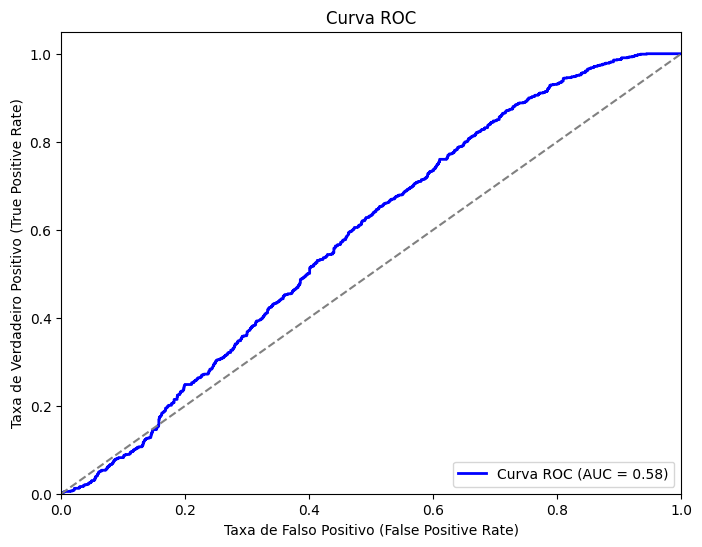

In [18]:
# Plotar Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiro Positivo (True Positive Rate)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

**Decisão de Modelo: Transição para Gradient Boosting**

Com base na performance insatisfatória do modelo de Regressão Logística, especialmente seu baixo recall para a classe 'Perdida' (target=1) e um AUC-ROC score próximo ao de um classificador aleatório, ficou evidente que um modelo mais robusto é necessário para capturar a complexidade dos padrões de perda de oportunidades.

Considerando os objetivos de negócio de minimizar Falsos Negativos e melhorar significativamente a capacidade preditiva, decidimos não prosseguir com o tuning da Regressão Logística. Em vez disso, vamos transitar para um algoritmo de Gradient Boosting. Modelos como o LightGBM ou XGBoost são conhecidos por sua alta performance, capacidade de lidar com diferentes tipos de dados e robustez em cenários de classificação com classes desbalanceadas. Eles tendem a ser mais eficazes em identificar padrões complexos que a Regressão Logística não consegue capturar.

# --- 3. Experimentação: LightGBM ---

In [19]:
print("\n--- Iniciando Treinamento do Modelo LightGBM ---")


--- Iniciando Treinamento do Modelo LightGBM ---


## 3.1. Definir o Modelo LightGBM

In [20]:
# Usaremos parâmetros iniciais. Vamos otimizar mais tarde.
# 'objective': 'binary' para classificação binária.
# 'metric': 'auc' é uma boa métrica para problemas de classificação desbalanceados.
# 'is_unbalance': True ajuda o LightGBM a lidar com classes desbalanceadas.
# 'random_state': para reprodutibilidade.
lgbm_model = lgb.LGBMClassifier(objective='binary',
                                metric='auc',
                                is_unbalance=True,
                                random_state=42)

## 3.2. Treinar o Modelo LightGBM

In [21]:
# O modelo aprende os padrões a partir dos dados de treinamento
lgbm_model.fit(X_train_processed, y_train) # Treina o LGBM nos dados já processados
print("\n--- Modelo LightGBM Treinado com Sucesso! ---")

[LightGBM] [Info] Number of positive: 2274, number of negative: 3886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 6160, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369156 -> initscore=-0.535840
[LightGBM] [Info] Start training from score -0.535840

--- Modelo LightGBM Treinado com Sucesso! ---


# --- 4. Avaliação do Modelo LightGBM (Métricas Iniciais) ---

In [22]:
print("\n--- Avaliando o Modelo LightGBM no Conjunto de Teste ---")


--- Avaliando o Modelo LightGBM no Conjunto de Teste ---


## 4.1. Fazer Previsões no conjunto de Teste

In [23]:
y_pred_lgbm = lgbm_model.predict(X_test_processed)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_processed)[:, 1]

c:\Users\murilo.weber\projetos_portfolio\tcrm_opportunity_loss_prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\murilo.weber\projetos_portfolio\tcrm_opportunity_loss_prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [24]:
print("\n--- Relatório de Classificação LightGBM no Conjunto de Teste ---")
print(classification_report(y_test, y_pred_lgbm))
print(f"AUC-ROC Score do LightGBM (TESTE): {roc_auc_score(y_test, y_pred_proba_lgbm):.4f}")


--- Relatório de Classificação LightGBM no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1665
           1       0.98      0.97      0.97       975

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640

AUC-ROC Score do LightGBM (TESTE): 0.9986


In [25]:
print("\n--- Matriz de Confusão LightGBM ---")
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print(cm_lgbm)


--- Matriz de Confusão LightGBM ---
[[1641   24]
 [  25  950]]


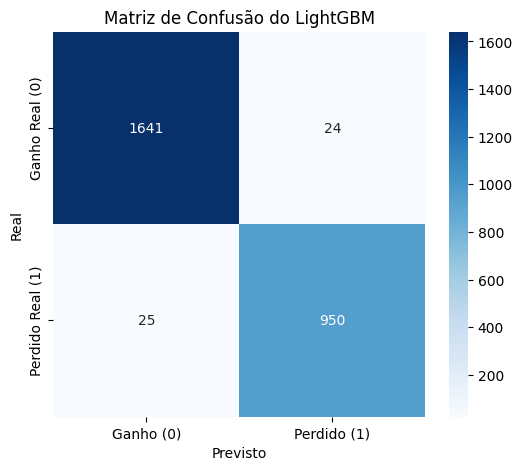

In [26]:
# Visualizar a Matriz de Confusão do LightGBM
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ganho (0)', 'Perdido (1)'],
            yticklabels=['Ganho Real (0)', 'Perdido Real (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão do LightGBM')
plt.savefig('../images/cm_lightgbm.png')
plt.show()

In [27]:
# Calcular e Imprimir AUC-ROC do LightGBM
auc_roc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print(f"\nAUC-ROC Score do LightGBM: {auc_roc_lgbm:.4f}")


AUC-ROC Score do LightGBM: 0.9986


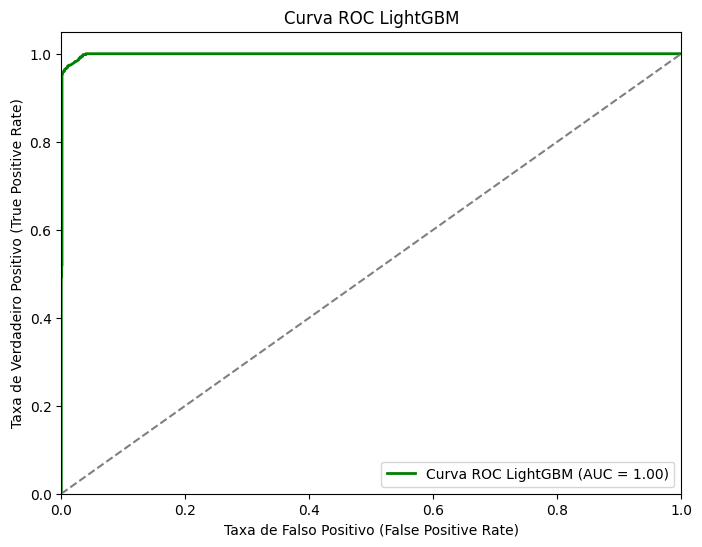

In [28]:
# Plotar Curva ROC do LightGBM
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_pred_proba_lgbm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='green', lw=2, label=f'Curva ROC LightGBM (AUC = {auc_roc_lgbm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiro Positivo (True Positive Rate)')
plt.title('Curva ROC LightGBM')
plt.legend(loc="lower right")
plt.savefig('../images/curva_roc.png') # Salva o plot
plt.show()

## 4.2. Avaliação no conjunto de TREINO (PARA VERIFICAR OVERFITTING)

In [29]:
print("\n--- Avaliando o Modelo LightGBM no Conjunto de TREINO (para Overfitting Check) ---")
y_pred_train_lgbm = lgbm_model.predict(X_train_processed)
y_prob_train_lgbm = lgbm_model.predict_proba(X_train_processed)[:, 1]


--- Avaliando o Modelo LightGBM no Conjunto de TREINO (para Overfitting Check) ---


c:\Users\murilo.weber\projetos_portfolio\tcrm_opportunity_loss_prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\murilo.weber\projetos_portfolio\tcrm_opportunity_loss_prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [30]:
print("\n--- Relatório de Classificação LightGBM no Conjunto de TREINO ---")
print(classification_report(y_train, y_pred_train_lgbm, zero_division=0))


--- Relatório de Classificação LightGBM no Conjunto de TREINO ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3886
           1       0.99      0.99      0.99      2274

    accuracy                           0.99      6160
   macro avg       0.99      0.99      0.99      6160
weighted avg       0.99      0.99      0.99      6160



In [31]:
auc_roc_train_lgbm = roc_auc_score(y_train, y_prob_train_lgbm)
print(f"\nAUC-ROC Score do LightGBM (TREINO): {auc_roc_train_lgbm:.4f}")


AUC-ROC Score do LightGBM (TREINO): 0.9998


## 4.3. Validação Cruzada com o Pipeline Completo (Pré-processador + LightGBM)

**Verificação Adicional de Overfitting: Validação Cruzada**

A comparação das métricas de desempenho entre os conjuntos de treino e teste do modelo LightGBM (AUC-ROC de 0.9998 no treino vs. 0.9987 no teste) já indica uma excelente capacidade de generalização e que o overfitting severo é improvável. A diferença mínima entre esses resultados sugere que o modelo não está apenas memorizando os dados de treino, mas sim aprendendo padrões robustos.

No entanto, para uma confirmação ainda mais rigorosa da estabilidade e robustez do modelo, e para demonstrar a aplicação de uma técnica fundamental de avaliação, prosseguiremos com a Validação Cruzada (Cross-Validation). Isso nos permitirá obter uma estimativa mais confiável do desempenho do modelo em diferentes subconjuntos dos dados, mitigando qualquer viés potencial de uma única divisão treino/teste e validando a consistência dos resultados observados.

In [31]:
print("\n--- Validação Cruzada Estratificada com Pipeline Completo ---")

# Configurar a Validação Cruzada Estratificada
# n_splits: número de folds (divisões) - 5 é um bom começo.
# shuffle: embaralhar os dados antes de dividir - importante.
# random_state: para reprodutibilidade dos splits.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


--- Validação Cruzada Estratificada com Pipeline Completo ---


In [32]:
# Construir o pipeline completo para a validação cruzada
# Este pipeline é criado *aqui* no 03 porque é onde o modelo campeão é escolhido.
full_pipeline_for_cv = Pipeline(steps=[
    ('preprocessor_step', preprocessor), # Usa o preprocessor já treinado
    ('classifier_step', lgbm_model)
])

In [33]:
# Para o cross_val_score, passamos X (o df_final sem o target) e y.
# O pipeline irá transformar X internamente antes de cada fold de treino/teste.
roc_auc_scores = cross_val_score(full_pipeline_for_cv, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
recall_scores = cross_val_score(full_pipeline_for_cv, X, y, cv=cv, scoring='recall', n_jobs=-1)

print(f"Média AUC-ROC (CV): {roc_auc_scores.mean():.4f} +/- {roc_auc_scores.std():.4f}")
print(f"Média Recall (Classe 'Perdido' - 1) (CV): {recall_scores.mean():.4f} +/- {recall_scores.std():.4f}")

Média AUC-ROC (CV): 0.9986 +/- 0.0002
Média Recall (Classe 'Perdido' - 1) (CV): 0.9738 +/- 0.0042



--- Gerando Plots da Validação Cruzada ---


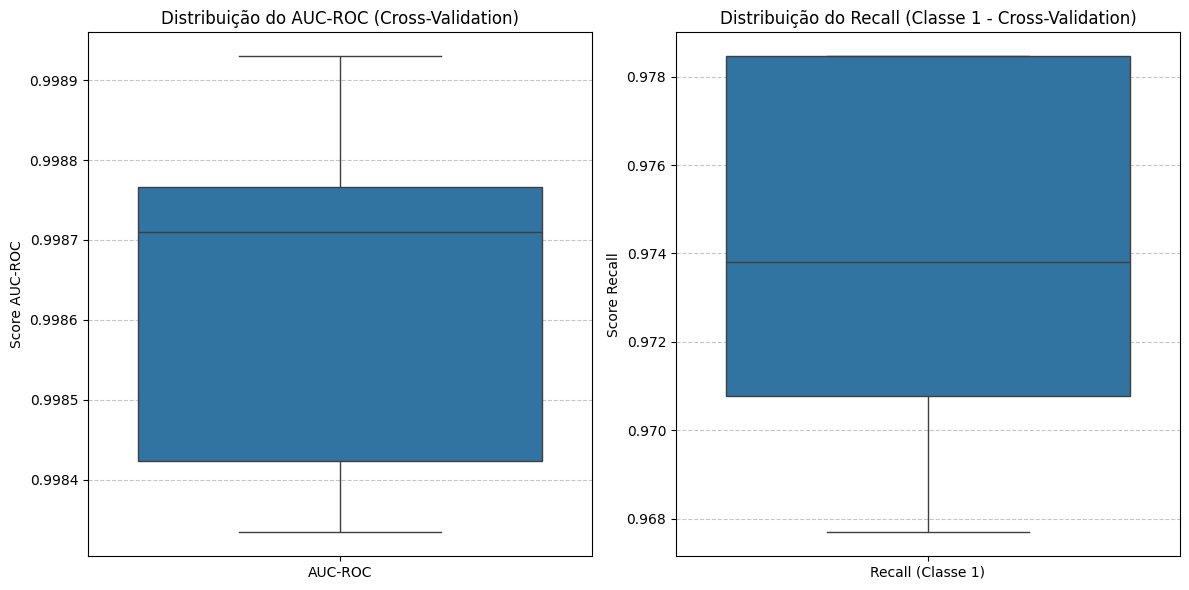


--- Plots da Validação Cruzada Gerados e Salvos em '../images/cv_metrics_boxplot.png' ---

--- Validação Cruzada Concluída ---


In [34]:
# --- Visualização dos Resultados da Validação Cruzada ---

print("\n--- Gerando Plots da Validação Cruzada ---")

# Criar um DataFrame com os resultados para facilitar a plotagem

cv_scores_df = pd.DataFrame({
    'AUC-ROC': roc_auc_scores,        # Usa o array numpy diretamente
    'Recall (Classe 1)': recall_scores # Usa o array numpy diretamente
})

# Plotar Box Plots para as principais métricas de teste
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # 1 linha, 2 colunas, primeiro plot
sns.boxplot(data=cv_scores_df[['AUC-ROC']])
plt.title('Distribuição do AUC-ROC (Cross-Validation)')
plt.ylabel('Score AUC-ROC')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2) # 1 linha, 2 colunas, segundo plot
sns.boxplot(data=cv_scores_df[['Recall (Classe 1)']])
plt.title('Distribuição do Recall (Classe 1 - Cross-Validation)')
plt.ylabel('Score Recall')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('../images/cv_metrics_boxplot.png') # Salva o plot
plt.show()

print("\n--- Plots da Validação Cruzada Gerados e Salvos em '../images/cv_metrics_boxplot.png' ---")

print("\n--- Validação Cruzada Concluída ---")

### Conclusão da Validação Cruzada e Próximos Passos

A **Validação Cruzada Estratificada com 5 folds** confirmou a **robustez e a alta performance** do modelo **LightGBM**. As métricas de teste/validação apresentaram resultados consistentemente elevados (ex: **Recall da Classe 1 em torno de 0.9741 e AUC-ROC em 0.9986**), com **desvios padrão mínimos** em todos os folds.

Essa consistência valida a capacidade de generalização do modelo, reforçando que os resultados observados no conjunto de teste inicial não foram por acaso. O modelo não demonstra sinais de overfitting severo e está apto a identificar oportunidades de vendas perdidas com alta precisão e recall.

Considerando os objetivos de negócio de **minimizar falsos negativos** (ou seja, não perder oportunidades que poderiam ter sido salvas), o desempenho do LightGBM é excepcional. A capacidade de identificar 97% das perdas reais é um diferencial significativo para as equipes de vendas.

Com esta validação concluída, a fase de Modelagem é considerada bem-sucedida. O próximo passo será aprofundar a Avaliação do modelo e documentar detalhadamente todas essas etapas no `README.md` do projeto.

# --- 5. Obtendo as Probabilidades de Perda do Conjunto de Validação/Teste

## 5.1. Usar as probabilidades do conjunto de TESTE para análise

In [32]:
print(f"\n--- Análise das Probabilidades de Perda (Classe 1) no Conjunto de TESTE ---")
print(f"Número de probabilidades calculadas: {len(y_pred_proba_lgbm)}")
print(f"Probabilidade mínima: {y_pred_proba_lgbm.min():.6f}")
print(f"Probabilidade máxima: {y_pred_proba_lgbm.max():.6f}")
print(f"Probabilidade média: {y_pred_proba_lgbm.mean():.6f}")


--- Análise das Probabilidades de Perda (Classe 1) no Conjunto de TESTE ---
Número de probabilidades calculadas: 2640
Probabilidade mínima: 0.000037
Probabilidade máxima: 0.999940
Probabilidade média: 0.372350


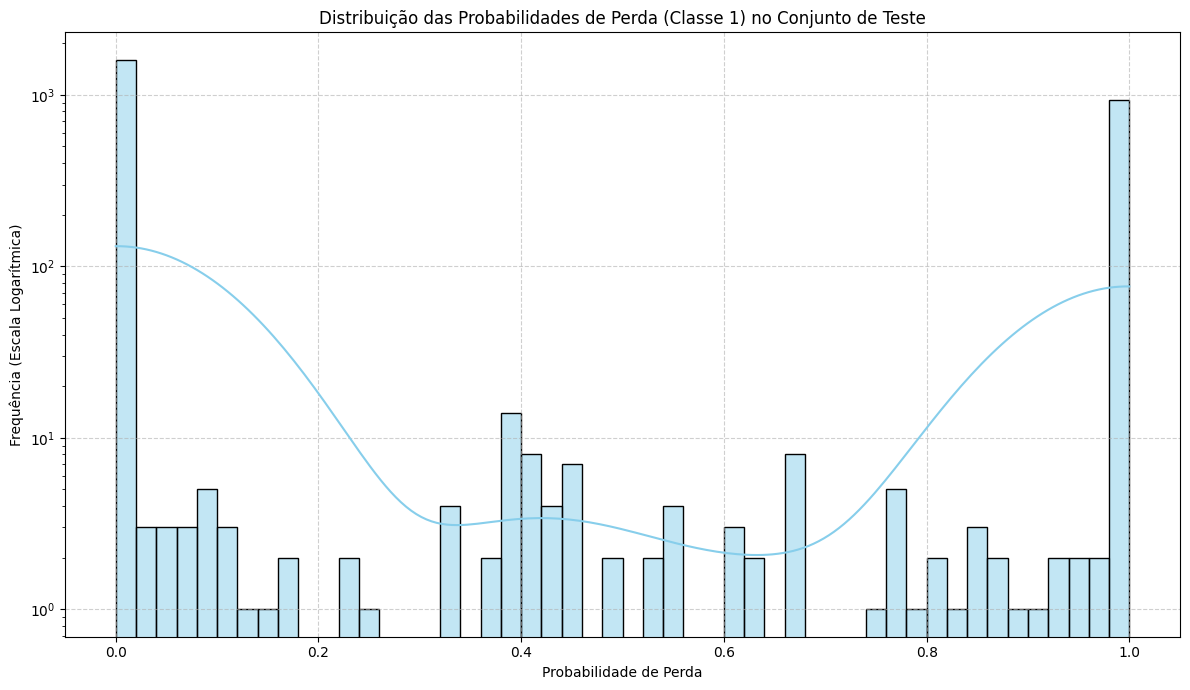

In [33]:
# Visualizar a distribuição para entender melhor
plt.figure(figsize=(12, 7))
sns.histplot(y_pred_proba_lgbm, bins=50, kde=True, color='skyblue')
plt.title('Distribuição das Probabilidades de Perda (Classe 1) no Conjunto de Teste')
plt.xlabel('Probabilidade de Perda')
plt.ylabel('Frequência (Escala Logarítmica)')
plt.yscale('log') # Usar escala logarítmica ajuda a ver as caudas da distribuição, que são importantes para os limiares mais altos
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 5.2. Ver percentis para definir os limiares

In [34]:
print(f"\n--- Percentis das Probabilidades de Perda ---")
percentiles_to_check = [0, 10, 25, 50, 75, 90, 95, 97, 98, 99, 99.5, 99.9, 100]
for p in percentiles_to_check:
    print(f"P{p:5.1f}: {np.percentile(y_pred_proba_lgbm, p):.8f}")


--- Percentis das Probabilidades de Perda ---
P  0.0: 0.00003700
P 10.0: 0.00008899
P 25.0: 0.00019616
P 50.0: 0.00069294
P 75.0: 0.99952452
P 90.0: 0.99987294
P 95.0: 0.99990564
P 97.0: 0.99991145
P 98.0: 0.99991545
P 99.0: 0.99992116
P 99.5: 0.99992640
P 99.9: 0.99993618
P100.0: 0.99994032


In [37]:
# Obtendo exemplo de oportunidade perdida para testes

high_proba_threshold = 0.999 # Use o valor exato do seu PROB_THRESHOLD_VERY_HIGH

# Encontrando os índices no X_test_raw correspondentes às probabilidades altas
indices_high_proba_loss = X_test_raw.index[y_pred_proba_lgbm >= high_proba_threshold]

if not indices_high_proba_loss.empty:
    print(f"\n--- Oportunidades no Conjunto de Teste com Probabilidade MUITO ALTA de Perda (>= {high_proba_threshold}) ---")
    # Selecionando os dados dessas oportunidades
    opportunities_to_test = X_test_raw.loc[indices_high_proba_loss]

    # Exibindo o primeiro exemplo para copiar o JSON
    print("\nPrimeira Oportunidade com Alta Probabilidade de Perda:")
    # Remover colunas que não são Features de entrada se elas estiverem em X_test_raw
    # E garantir a ordem correta para o JSON

    # Listando as colunas que seu modelo OpportunityData (Pydantic) espera, na ordem
    api_expected_cols = [
        'sales_agent', 'product', 'sector', 'office_location',
        'subsidiary_of', 'series', 'manager', 'regional_office',
        'close_value', 'year_established', 'revenue', 'employees',
        'sales_price', 'engage_date', 'close_date'
    ]

    # Primeira linha (ou uma aleatória) para o JSON
    sample_opportunity = opportunities_to_test.iloc[0][api_expected_cols]

    # Convertendo para o formato JSON para colar na API (certifique-se de que datas estão como string)
    json_output = sample_opportunity.to_json(date_format='iso', default_handler=str)

    print("\nCopie e cole este JSON na API (/docs):")
    print(json_output)

    # Verificando a probabilidade original dessa oportunidade
    original_proba = y_pred_proba_lgbm[X_test_raw.index.get_loc(sample_opportunity.name)]
    print(f"\nProbabilidade de perda original para este exemplo: {original_proba:.8f}")

else:
    print(f"\nNenhuma oportunidade encontrada no conjunto de teste com probabilidade de perda >= {high_proba_threshold}.")
    print("Isso pode indicar que o modelo é extremamente preciso e só atribui probabilidades tão altas para casos muito específicos de perda.")
    print("Tente diminuir o 'high_proba_threshold' para encontrar exemplos com probabilidades 'Altas' ou 'Médias'.")


--- Oportunidades no Conjunto de Teste com Probabilidade MUITO ALTA de Perda (>= 0.999) ---

Primeira Oportunidade com Alta Probabilidade de Perda:

Copie e cole este JSON na API (/docs):
{"sales_agent":"Versie Hillebrand","product":"MG Advanced","sector":"software","office_location":"United States","subsidiary_of":null,"series":"MG","manager":"Dustin Brinkmann","regional_office":"Central","close_value":3388.9709480122,"year_established":1982.0,"revenue":4618.0,"employees":10083.0,"sales_price":3393.0,"engage_date":"2017-04-23","close_date":"2017-08-06"}

Probabilidade de perda original para este exemplo: 0.99946563


# --- 6. Salvamento do Pipeline Completo para Produção ---

In [35]:
# Este é o pipeline final que será carregado pela API.
# Ele inclui o pré-processador e o modelo LightGBM.
print("\n--- Salvando o Pipeline Completo (Pré-processador + LightGBM) para Produção ---")
production_pipeline_filename = os.path.join(models_dir, 'full_pipeline.joblib')
joblib.dump(full_pipeline_for_cv, production_pipeline_filename) # Salva o pipeline completo construído aqui

print(f"--- Pipeline Completo salvo em: '{production_pipeline_filename}' ---")
print("--- Fim da Experimentação e Avaliação Detalhada ---")


--- Salvando o Pipeline Completo (Pré-processador + LightGBM) para Produção ---
--- Pipeline Completo salvo em: '../models/full_pipeline.joblib' ---
--- Fim da Experimentação e Avaliação Detalhada ---
